In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pystan
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from causalpy.bayesian_networks import LinearGaussianBN
import sympy as sym
from sympy import init_printing
init_printing(use_latex=True)
%matplotlib inline

 There are two things we could priors on that we should think about. 
 
 1)  The distributions over input variables (and if those variable can take say positive or negative values)
 
 2)  The size and sign of coefficients
 

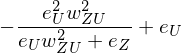

In [2]:
model = LinearGaussianBN()
model.add_var("U",[])
model.add_var("Z",["U"])
model.observe(["Z"],["z"]).cov[0]

In [3]:
from sympy import Symbol
model = LinearGaussianBN()
model.add_var("U",[])
model.add_var("Z",[])
model.add_var("Y",["U","Z"])

print model
a = sym.simplify(model.marginal(['Z','Y']).observe(["Z"],["z"]).cov[0])
print a.subs({"V_U":1,"V_Z":1,"V_Y":1,"w_YU":2,"w_ZU":3})
print (Symbol("w_YU")*Symbol("w_YU") * Symbol("V_U")+Symbol("V_Y")).subs({"V_U":1,"V_Z":1,"V_Y":1,"w_YU":2,"w_ZU":3})
a

U ~ N(w_U0 ; e_U)
Z ~ N(w_Z0 ; e_Z)
Y ~ N(w_Y0 + w_YU*U + w_YZ*Z ; e_Y)

4*e_U + e_Y
5


In [4]:
def plot_posteriors(fit,name):
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    beta = fit.extract()['beta']
    sns.kdeplot(beta, shade=True,ax=ax[1])
    sns.kdeplot(fit.extract()['w_yx'],shade=True,ax=ax[0])
    ax[1].set_xlabel("$\\beta$")
    ax[0].set_xlabel("$w_{yx}$")
    ax[1].set_title("Posterior for $\\beta$")
    ax[0].set_title("Posterior for $w_{yx}$")
    fig.tight_layout()
    fig.savefig(name,dpi=1200)
    return fig,ax

In [5]:
def subdict(d,drop):
    result = d.copy()
    for key in drop:
        result.pop(key)
    return result

def linear_regression(data):
    X = np.vstack([data['Z'],data['X']]).T
    y = data['Y']
    lr = LinearRegression()
    lr.fit(X,y)
    return lr.coef_

In [6]:
def sample():
    u = np.random.normal(0,s_u,size=n)
    z = w_zu*u + np.random.normal(0,s_z,size=n)
    x = w_xz*z+np.random.normal(0,s_x,size=n)
    y = w_yx*x + w_yz*z + w_yu*u+ np.random.normal(0,s_y,size=n)
    return {"U":u,"Z":z,"X":x,"Y":y}
    
data_dict = sample()
df1 = pd.DataFrame(data_dict,columns=["U","Z","X","Y"])
df1.cov()

NameError: global name 's_u' is not defined

U ~ N(w_U0 ; e_U)
Z ~ N(w_Z0 + w_ZU*U ; e_Z)
Y ~ N(w_Y0 + w_YU*U + w_YZ*Z ; e_Y)

(0.09*e_U*e_Y + 0.16*e_U*e_Z + e_Y*e_Z)/(0.09*e_U + e_Z)
5.01600000000000


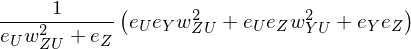

In [7]:
from sympy import Symbol
model = LinearGaussianBN()
model.add_var("U",[])
model.add_var("Z",["U"])
model.add_var("Y",["U","Z"])

print model
a = sym.simplify(model.marginal(['Z','Y']).observe(["Z"],["z"]).cov[0])
#{eu -> .1, ey -> 5, wyu -> -.4, ez -> 2, wzu -> .3}
d = {"V_U":.1,"V_Z":2,"V_Y":5,"w_YU":.4,"w_ZU":.3}
print a.subs(d)
print (Symbol("w_YU")*Symbol("w_YU") * Symbol("V_U")+Symbol("V_Y")).subs(d)
a

U ~ N(w_U0 ; e_U)
Z ~ N(w_Z0 + w_ZU*U ; e_Z)
X ~ N(w_X0 + w_XZ*Z ; e_X)
Y ~ N(w_Y0 + w_YU*U + w_YZ*Z + w_YX*X ; e_Y)



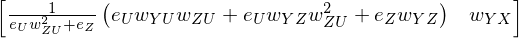

In [8]:
model = LinearGaussianBN()
model.add_var("U",[])
model.add_var("Z",["U"])
model.add_var("X",["Z"])
model.add_var("Y",["U","Z","X"])

print model
m2 = model.marginal(["Z","X","Y"])
coef = sym.simplify(m2.regression_matrix(["Z","X"]))
coef

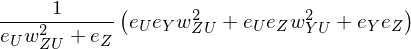

In [9]:
m3 = m2.observe(["Z","X"],["z","x"])
sym.simplify(m3.cov[0])

## Stan fits

In [10]:
s_u = 1
s_z = 0.3
s_x = 1
s_y = 0.5

w_zu = 2
w_xz = 0.5
w_yx = 0.5
w_yz = -1.0
w_yu = 3.0


beta_x = 0.5
beta_z = -1
sigma = 0.5
n = 1000

beta = w_yz+(w_yu*w_zu)/(w_zu**2+(s_z**2/s_u**2))
print beta

0.466992665037


In [31]:
model = LinearGaussianBN()
model.add_var("U",None,[0],s_u**2)
model.add_var("Z",["U"],[0,w_zu],s_z**2)
model.add_var("X",["Z"],[0,w_xz],s_x**2)
model.add_var("Y",["U","Z","X"],[0,w_yu,w_yz,w_yx],s_y**2)

print model
data_dict = dict(zip(model.variables,model.sample(n).T))
df = pd.DataFrame(data_dict,columns=model.variables)
data = subdict(data_dict,"U")
df.cov()

U ~ N(0 ; 1)
Z ~ N(2*U ; 0.09)
X ~ N(0.5*Z ; 1)
Y ~ N(3*U + -1*Z + 0.5*X ; 0.25)



,U,Z,X,Y
U,0.948824,1.902366,0.934367,1.424546
Z,1.902366,3.911570,1.920174,2.773023
X,0.934367,1.920174,1.932943,1.847490
Y,1.424546,2.773023,1.847490,2.676476


In [32]:
#beta, w_yx
linear_regression(data_dict)

array([ 0.46791437,  0.49096768])

In [33]:
stan_model_no_prior = """
data {
   int<lower=4> N; // Number of data points
   real X[N];      // the 1st predictor
   real Z[N];      // the 2nd predictor
   real Y[N];      // the outcome
}
parameters {
   real w_yx;     // x-slope
   real beta;     // z-slope
   real<lower=0> eps;       // dispersion
}
model {
   for (i in 1:N){
      Y[i] ~ normal(w_yx * X[i] + beta * Z[i], eps);
      }
}"""
data["N"] = n
fit_no_prior = pystan.stan(model_code=stan_model_no_prior, data=data, iter=10000, chains=4)

In [34]:
def plot_posteriors(fit,name):
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    beta = fit.extract()['beta']
    sns.kdeplot(beta, shade=True,ax=ax[1])
    sns.kdeplot(fit.extract()['w_yx'],shade=True,ax=ax[0])
    ax[1].set_xlabel("$\\beta$")
    ax[0].set_xlabel("$w_{yx}$")
    ax[1].set_title("Posterior for $\\beta$")
    ax[0].set_title("Posterior for $w_{yx}$")
    fig.tight_layout()
    fig.savefig(name,dpi=1200)
    return fig,ax

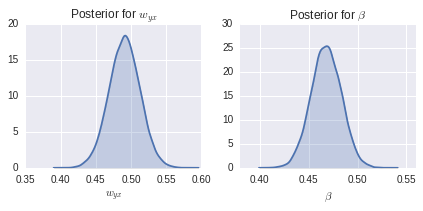

In [35]:
fig,ax = plot_posteriors(fit_no_prior,"prior_no_prior.pdf")


In [36]:
#      w_yx ~ normal(0,5);
stan_model_with_prior = """
data {
   int<lower=4> N; // Number of data points
   real X[N];      // the 1st predictor
   real Z[N];      // the 2nd predictor
   real Y[N];      // the outcome
}
parameters {
   real w_yx;     // x-slope
   real beta;     // z-slope
   real<lower=0> eps;       // dispersion
}
model {
   for (i in 1:N){
      beta ~ normal(-1,.5);
      Y[i] ~ normal(w_yx * X[i] + beta * Z[i], eps);
      }
}"""
data["N"] = n
fit_bad_prior = pystan.stan(model_code=stan_model_with_prior, data=data, iter=10000, chains=4)

(<matplotlib.figure.Figure at 0x7f917db797d0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9175536ed0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f917df27050>], dtype=object))

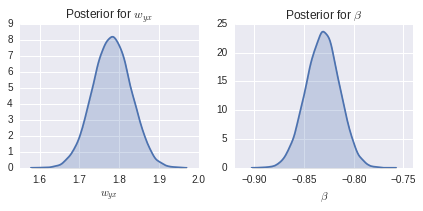

In [37]:
plot_posteriors(fit_bad_prior,"prior_bad_prior.pdf")

In [38]:
stan_model_with_prior2 = """
data {
   int<lower=4> N; // Number of data points
   real X[N];      // the 1st predictor
   real Z[N];      // the 2nd predictor
   real Y[N];      // the outcome
}
parameters {
   real w_yx;     // x-slope
   real w_yz;     // z-slope
   real<lower=0> eps;       // dispersion
}
model {
   for (i in 1:N){
      w_yx ~ normal(0,5);
      w_yz ~ normal(.46,.5);
      Y[i] ~ normal(w_yx * X[i] + w_yz * Z[i], eps);
      }
}"""
data["N"] = n
fit_good_prior = pystan.stan(model_code=stan_model_with_prior2, data=data, iter=10000, chains=4)

In [51]:
15.0/47

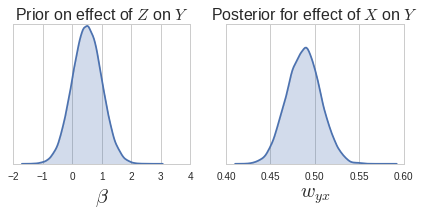

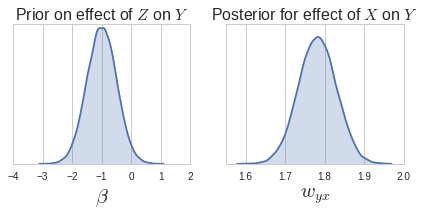

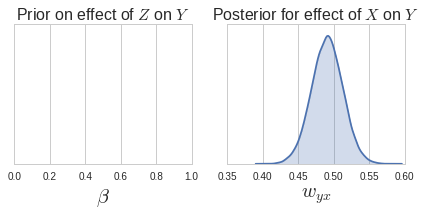

In [49]:
#There are five preset seaborn themes: darkgrid, whitegrid, dark, white, and ticks

prior_loc = 0.5
prior_scale=0.5

def plot_prior_posterior(name,fit,prior_loc,prior_scale): 
    sns.set_style('whitegrid')
    fig,ax = plt.subplots(1,2,figsize=(7,2.5))
   
    if prior_loc is not None:
        x = np.random.normal(loc=prior_loc,scale=prior_scale,size=100000)
        sns.kdeplot(x,shade=True,ax=ax[0])
    
   
    sns.kdeplot(fit.extract()['w_yx'],shade=True,ax=ax[1])
    ax[0].set_title("Prior on effect of $Z$ on $Y$")
    ax[0].set_xlabel("$\\beta$")
    #ax[0].xaxis.set_visible(False)
    ax[0].yaxis.set_visible(False)


    ax[1].yaxis.set_visible(False)
    ax[1].set_xlabel('$w_{yx}$')
    ax[1].set_title('Posterior for effect of $X$ on $Y$')
    #ax.get_xticklabels() + ax.get_yticklabels()
    for a in ax:
        a.xaxis.label.set_fontsize(20)
        a.title.set_fontsize(16)
        #for item in ([a.title, a.xaxis.label, a.yaxis.label]):
        #    item.set_fontsize(20)
    fig.savefig(name+".pdf",dpi=1200,bbox_inches="tight")
            
plot_prior_posterior("prior_good",fit_good_prior,.5,.5)
plot_prior_posterior("prior_bad",fit_bad_prior,-1,.5)
plot_prior_posterior("prior_none",fit_no_prior,None,None)

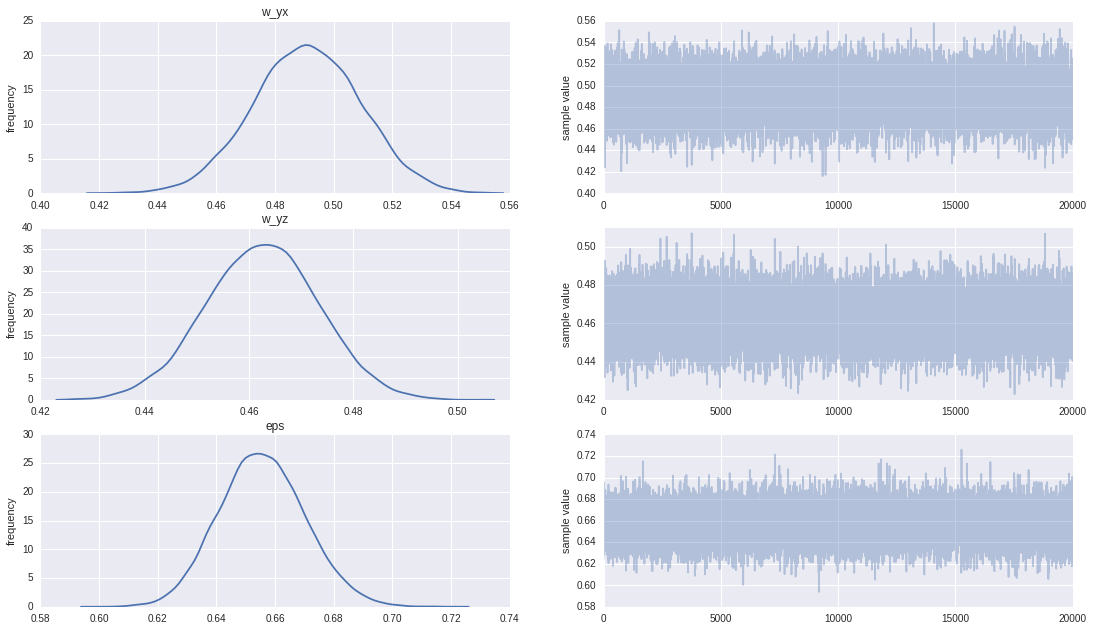

In [57]:
fit.plot()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig("prior_good_prior.pdf")

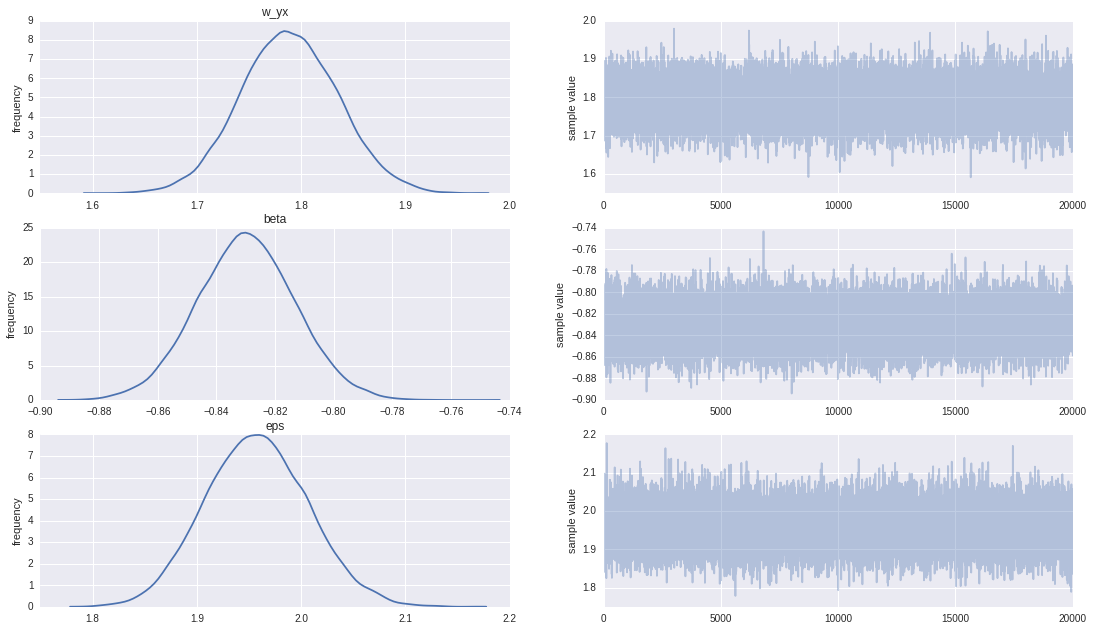

In [45]:
fit.plot()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig("prior_bad_prior.pdf")